In [12]:
from collections import defaultdict
import time
import os

import numpy as np

from tqdm import tqdm

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn

import torchvision.utils as vutils

cudnn.benchmark = True
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [13]:
import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [14]:
data_size = dict()

for data_flag in INFO.keys():
    n_samples = INFO[data_flag]['n_samples']
    data_size[data_flag] = n_samples
    
print(data_size)

{'pathmnist': {'train': 89996, 'val': 10004, 'test': 7180}, 'chestmnist': {'train': 78468, 'val': 11219, 'test': 22433}, 'dermamnist': {'train': 7007, 'val': 1003, 'test': 2005}, 'octmnist': {'train': 97477, 'val': 10832, 'test': 1000}, 'pneumoniamnist': {'train': 4708, 'val': 524, 'test': 624}, 'retinamnist': {'train': 1080, 'val': 120, 'test': 400}, 'breastmnist': {'train': 546, 'val': 78, 'test': 156}, 'bloodmnist': {'train': 11959, 'val': 1712, 'test': 3421}, 'tissuemnist': {'train': 165466, 'val': 23640, 'test': 47280}, 'organamnist': {'train': 34581, 'val': 6491, 'test': 17778}, 'organcmnist': {'train': 13000, 'val': 2392, 'test': 8268}, 'organsmnist': {'train': 13940, 'val': 2452, 'test': 8829}, 'organmnist3d': {'train': 972, 'val': 161, 'test': 610}, 'nodulemnist3d': {'train': 1158, 'val': 165, 'test': 526}, 'adrenalmnist3d': {'train': 1188, 'val': 98, 'test': 298}, 'fracturemnist3d': {'train': 1027, 'val': 103, 'test': 240}, 'vesselmnist3d': {'train': 1335, 'val': 192, 'test':

In [16]:
data_flag = 'organamnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [17]:
DataClass, n_channels, n_classes

(medmnist.dataset.OrganAMNIST, 1, 11)

In [20]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True)

train_loader_at_eval = DataLoader(dataset=train_dataset, 
                                       batch_size=2*BATCH_SIZE, 
                                       shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                              batch_size=2*BATCH_SIZE, 
                              shuffle=False)

Using downloaded and verified file: /Users/chi-hsuanchang/.medmnist/organamnist.npz
Using downloaded and verified file: /Users/chi-hsuanchang/.medmnist/organamnist.npz
Using downloaded and verified file: /Users/chi-hsuanchang/.medmnist/organamnist.npz


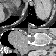

In [21]:
# visualization
train_dataset.montage(length=2)

In [8]:

    add_random_noise(mean=0.2, std=0.1)

tensor([[ 0.5418, -0.5662,  2.6271, -0.5097]])

In [10]:
import utils
from utils.preprocessing import * 

In [15]:
INFO['organamnist']

{'python_class': 'OrganAMNIST',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.',
 'url': 'https://zenodo.org/record/5208230/files/organamnist.npz?download=1',
 'MD5': '866b832ed4eeba67bfb9edee1d5544e6',
 'task': 'multi-class',
 'label': {'0': 'bladder',
  '1': 'femur-left',
  '2': 'femur-right',
  

In [17]:
INFO['organsmnist']

{'python_class': 'OrganSMNIST',
 'description': 'The OrganSMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Sagittal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in sagittal views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.',
 'url': 'https://zenodo.org/record/5208230/files/organsmnist.npz?download=1',
 'MD5': 'e5c39f1af030238290b9557d9503af9d',
 'task': 'multi-class',
 'label': {'0': 'bladder',
  '1': 'femur-left',
  '2': 'femur-righ

In [19]:
INFO['organcmnist']

{'python_class': 'OrganCMNIST',
 'description': 'The OrganCMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Coronal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in coronal views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.',
 'url': 'https://zenodo.org/record/5208230/files/organcmnist.npz?download=1',
 'MD5': '0afa5834fb105f7705a7d93372119a21',
 'task': 'multi-class',
 'label': {'0': 'bladder',
  '1': 'femur-left',
  '2': 'femur-right'

In [20]:
INFO['organmnist3d']

{'python_class': 'OrganMNIST3D',
 'description': 'The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.',
 'url': 'https://zenodo.org/record/5208230/files/organmnist3d.npz?download=1',
 'MD5': '21f0a239e7f502e6eca33c3fc453c0b6',
 'task': 'multi-class',
 'label': {'0': 'liver',
  '1': 'kidney-right',
  '2': 'kidney-left',
  '3': 'femur-right',
  '4': 'femur-left',
  '5': 'bladder',
  '6': 'heart',
  '7': 'lung-right',
  '8': 'lung-left',
  '9': 'spleen',
  '10': 'pancreas'},
 'n_channels': 1,
 'n_samples': {'train': 972, 'val': 161, 'test': 610},
 'license': 'CC BY 4.0'}